In [1]:
from sympy import symbols, init_printing
import sympy
import sympy.physics.mechanics as me
init_printing(use_latex='mathjax')
import seaborn as sns
# sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
import matplotlib.pyplot as plt
from scipy.integrate import ode, odeint
import numpy as np
%matplotlib inline
import InputShaping as shaping

//anaconda/envs/py2p7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# Create the variables
x, y, beta = me.dynamicsymbols('x, y, beta')

# Create the velocities
x_dot, y_dot, beta_dot = me.dynamicsymbols('x, y, beta', 1)

# Create the constants
m, k, L, g, H, c, D,t, Izz, k_beta, c_beta = sympy.symbols('m k L g H c D t Izz k_beta c_beta')
L_1_init, L_2_init = sympy.symbols('L_1_init L_2_init')
# m = mass
# k = spring k
# L = spring equilibrium length
# g = gravity
# c = spring c
# c_beta = rotational c
# k_beta = rotational k
# D = rod length
# Izz = moment of Inertia about the end of a rod

In [3]:
# Create the world frame
N = me.ReferenceFrame('N')

# Create the rod frame
B = N.orientnew('B', 'axis', [beta, N.z])

# Set the rotation of the rod frame
B.set_ang_vel(N, beta_dot * N.z)

# Create the Origin
O1 = me.Point('O_1')

# Set origin velocity to zero
O1.set_vel(N, 0 * N.x)

# Create the second attachment point
O2 = O1.locatenew('O_2', H * N.x)
O2.set_vel(N, 0 * N.x)

# Locate the point in the N frame
# P = me.Point('pen')
P = O1.locatenew('P', x * N.x + y * N.y)

# P.set_pos(O1, x * N.x + y * N.y)

# Set the point's velocity
P.set_vel(N, x_dot * N.x + y_dot * N.y)

# Create the rod center of mass
G = P.locatenew('G', D/2 * B.y)

# Set the velocity of G
G.v2pt_theory(P, N, B)

# Create the rod
I_rod = me.inertia(B, 0, 0, Izz)
rod = me.RigidBody('rod', G, B, m, (I_rod, G))

# Create the distance from the point to each attachment point
L1 = O1.pos_from(P).magnitude
L2 = O2.pos_from(P).magnitude
L1_vector = O1.pos_from(P).normalize
L2_vector = O2.pos_from(P).normalize

# Create the height from the center of gravity to the datum
h = G.pos_from(O1) & N.y

# The forces at the connection point
forceP = c * (x_dot + y_dot) * L1_vector() + c * (x_dot + y_dot) * L2_vector()

# The forces on the beta frame
forceB = -c_beta * beta_dot * N.z

rod.potential_energy = (-m * g * h + 0.5 * k * (L1() - L_1_init)**2 + 0.5 * k *(L2() - 
                        L_2_init)**2 + 0.5 * k_beta * beta**2)

Lag = me.Lagrangian(N, rod)

In [4]:
# x_eq = ((sympy.diff(sympy.diff(Lag, x_dot), t) + sympy.diff(-0.5 * c * x_dot**2, x_dot) - 
# sympy.diff(Lag, x)))

In [5]:
# y_eq = ((sympy.diff(sympy.diff(Lag, y_dot), t) + sympy.diff(0.5 * c * y_dot**2, y_dot) - 
# sympy.diff(Lag, y)))


In [6]:
# beta_eq = (sympy.diff(sympy.diff(Lag, beta_dot), t) + 
#              sympy.diff(0.5 * c_beta * beta_dot**2, beta_dot) - sympy.diff(Lag, beta))

In [7]:
LM = me.LagrangesMethod(Lag, [x, y, beta], forcelist=[(P, forceP), (B, forceB)], frame=N)

In [8]:
EqMotion = LM.form_lagranges_equations()
# sympy.simplify(EqMotion)

In [9]:
lrhs = LM.rhs()
# me.mprint(LM.forcing)

In [10]:
# def Length1(t):
#     # This is essentially a step input with a linear rise time
#     # set the velocity
#     v = 1
    
#     # set the inital cable lengths
#     init_length = 10.0
    
#     # set begin motion time
#     time1 = 2
#     time2 = 6
#     move = v*t
    
#     return (((((t>=time1) * (t<=time2)) * (init_length + move)) + (t<time1)*init_length) + 
#              (t>time2)*(init_length + v*time2))

In [11]:
# def Length2(t):
#     # This is essentially a step input with a linear rise time
#     # set the velocity
#     v = 0.5
    
#     # set the inital cable lengths
#     init_length = 15.0
    
#     # set begin motion time
#     time1 = 2
#     time2 = 6
#     move = v*t
    
#     return (((((t>=time1) * (t<=time2)) * (init_length - move)) + (t<time1)*init_length) + 
#              (t>time2)*(init_length - v*time2))

In [12]:
def s_curve(CurrTime, Begin, Amp, RiseTime, StartTime):
    """
    This was copied from Dr Vaughan's Input shaping Library
    I edited it to allow for a beginning value
    
    Function to generate an s-curve command
    
    Arguments:
      CurrTime : The current timestep or an array of times
      Amp : The magnitude of the s-curve (or final setpoint)
      RiseTime : The rise time of the curve
      StartTime : The time that the command should StartTime
      Begin : The beginnning value
      
    Returns :
      The command at the current timestep or an array representing the command
      over the times given (if CurrTime was an array)
    """

    Amp = Amp - Begin
    scurve = 2.0 * ((CurrTime - StartTime)/RiseTime)**2 * (CurrTime-StartTime >= 0) * (CurrTime-StartTime < RiseTime/2) \
            +(-2.0 * ((CurrTime - StartTime)/RiseTime)**2 + 4.0 * ((CurrTime - StartTime)/RiseTime) - 1.0) * (CurrTime-StartTime >= RiseTime/2) * (CurrTime-StartTime < RiseTime) \
            + 1.0 * (CurrTime-StartTime >= RiseTime)
    
    return (Amp * scurve) + Begin

In [25]:
# Going with 500rpm
# example_shaper = shaping.EI(0.329, 0.101)
example_shaper = shaping.ZVD(0.32, 0.032272678421545214)
# example_shaper = shaping.ZV_EI_2mode(.466053, 0.032272, .466053, 0.032272)
# example_shaper = shaping.UMZVD(.46605358040201028, 0.032272678421545214)
# example_shaper = shaping.ZVD_2mode(0.40160804, 0.07159188, 0.047746, 0.0)
Shaper = example_shaper.shaper

# a = shaping.shaped_input(s_curve, t, Shaper, 10.0,13.0,5.0,3.0)

In [26]:
length_of_rod = 1.0
mass = 1.0
inertia = length_of_rod * (1.0/3.0) * mass

In [31]:
# Define the states and state vector
w1, w2, w3, w4, w5, w6 = sympy.symbols('w1 w2 w3 w4 w5 w6', cls=sympy.Function)
w = [w1(t), w2(t), w3(t), w4(t), w5(t), w6(t)]

# Set up the state definitions and parameter substitution
sub_params = {x : w1(t),
              y : w2(t),
              beta: w3(t),
              x_dot: w4(t),
              y_dot: w5(t),
              beta_dot: w6(t),
              m : mass,
              g : 9.81,
              k : 10.0,
#               L_1_init: shaping.shaped_input(s_curve, t, Shaper, 15.62,25,9.0,3.0),
#               L_2_init: shaping.shaped_input(s_curve, t, Shaper, 15.62,20.61,9.0,3.0),
              L_1_init:s_curve(t, 15.62, 25.0, 9.0, 3.0),
              L_2_init:s_curve(t, 15.62, 20.61, 9.0, 3.0),
#               L_1_init: 15,
#               L_2_init: 15,
              H : 20.0,
              c : 1.0,
              D : length_of_rod,
              Izz: inertia,
              k_beta: 1.0,
              c_beta: 1.0}

# set this parameter to enable array output from sympy.lambdify
mat2array = [{'ImmutableMatrix': np.array}, 'numpy']

# Create a function from the equations of motion
# Here, we substitude the states and parameters as appropriate prior to the lamdification
eq_of_motion = sympy.lambdify((t, w), 
                              lrhs.subs(sub_params), 
                              modules = mat2array)

In [32]:
end_time = 60.0

x0 = [10, 12, 0.0, 0.0, 0.0, 0.0]

# Positive beta is to the left when facing the structure
sim_time = np.linspace(0.0, end_time, 1000)

In [33]:
# Set up the initial point for the ode solver
r = ode(eq_of_motion).set_initial_value(x0, sim_time[0])
 
# define the sample time
dt = sim_time[1] - sim_time[0]   

# pre-populate the response array with zeros
response = np.zeros((len(sim_time), len(x0)))

# Set the initial index to 0
index = 0

# Now, numerically integrate the ODE while:
#   1. the last step was successful
#   2. the current time is less than the desired simluation end time
while r.successful() and r.t < sim_time[-1]:
    response[index, :] = r.y
    r.integrate(r.t + dt)
    index += 1
    
np.savetxt("response.csv", response, delimiter=",")
# np.savetxt("response_shaped.csv", response2, delimiter=",")
# np.savetxt("sim_time.csv", sim_time, delimiter=",")

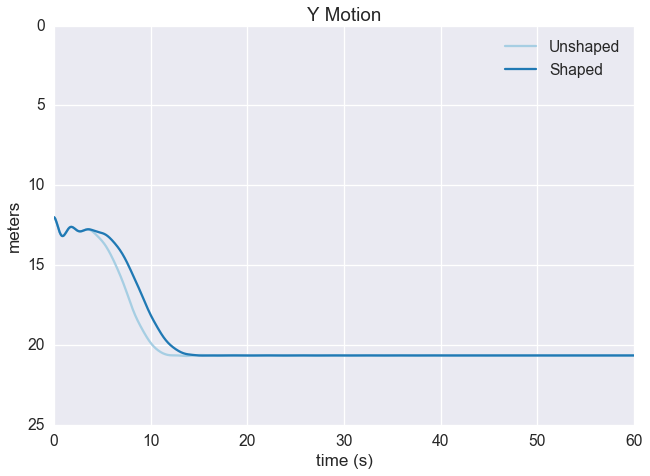

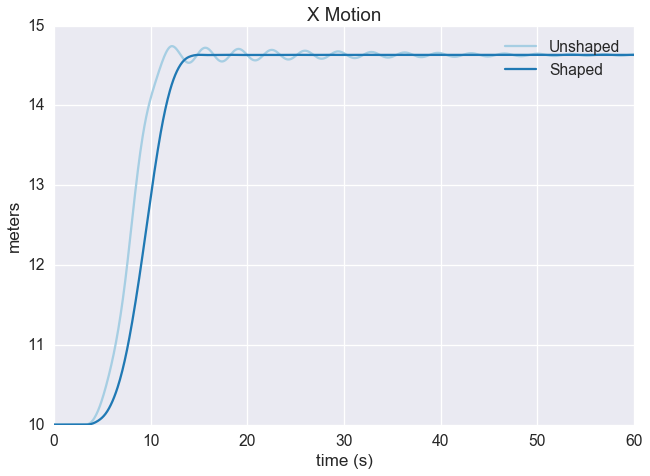

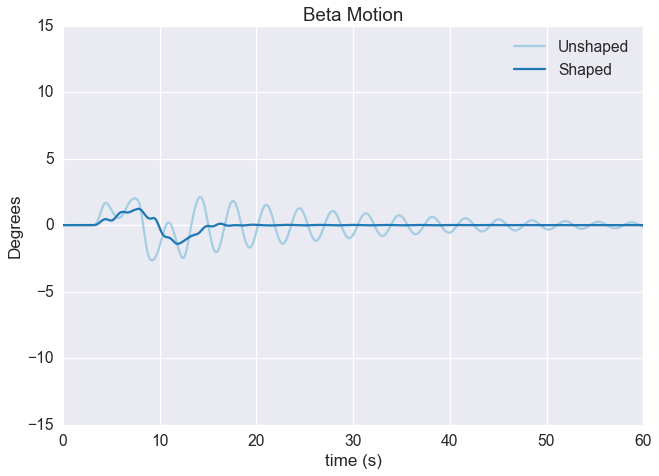

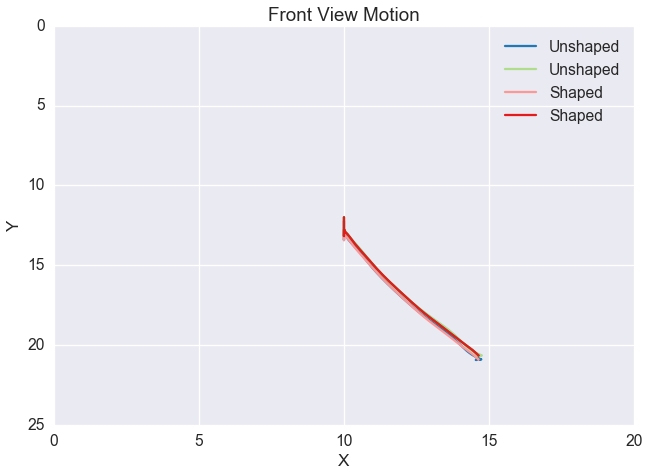

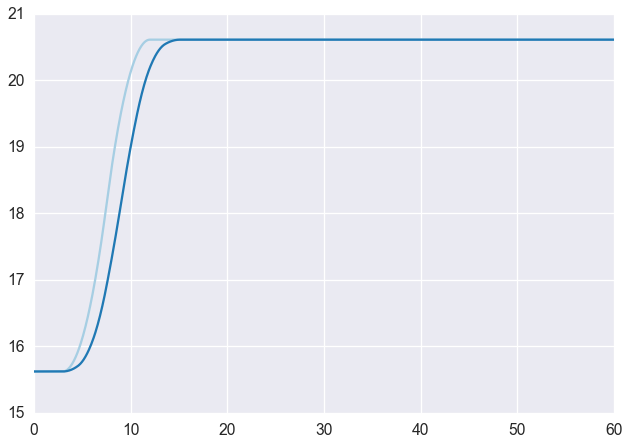

In [34]:
sns.set_palette("Paired")
sns.set_context("talk", font_scale=1.2)
sns.set_style("darkgrid")

plt.figure(0)
# plt.subplot(211)
plt.plot(sim_time, response[:,1], label='Unshaped')
plt.plot(sim_time, response2[:,1], label ='Shaped')
plt.ylim(25,0)
plt.legend()
plt.title('Y Motion')
plt.xlabel('time (s)')
plt.ylabel('meters')

plt.figure(1)
# plt.subplot(211)
plt.plot(sim_time, response[:,0], label='Unshaped')
plt.plot(sim_time, response2[:,0], label ='Shaped')
plt.legend()
plt.title('X Motion')
plt.xlabel('time (s)')
plt.ylabel('meters')

plt.figure(2)
# plt.subplot(211)
plt.plot(sim_time, np.degrees(response[:,2]), label='Unshaped')
plt.plot(sim_time, np.degrees(response2[:,2]), label ='Shaped')
plt.legend()
# plt.plot(sim_time, np.degrees(response2[:,2]))
plt.ylim(-15,15)
plt.xlim(0,60)
plt.title('Beta Motion')
plt.xlabel('time (s)')
plt.ylabel('Degrees')
# plt.savefig("Beta_Motion.pdf")

plt.figure(3)
# plt.subplot(212)
plt.plot(response[:,0], response[:,1])
plt.plot(response[:,0] + 0.5/2 * np.sin(response[:,2]) , response[:,1] + 0.5/2 * np.cos(response[:,2]), label='Unshaped')
plt.plot(response[:,0] + 1/2 * np.sin(response[:,2]) , response[:,1] + 1/2 * np.cos(response[:,2]), label='Unshaped')

plt.plot(response2[:,0], response2[:,1])
plt.plot(response2[:,0] + 0.5/2 * np.sin(response2[:,2]) , response2[:,1] + 0.5/2 * np.cos(response2[:,2]), label ='Shaped')
plt.plot(response2[:,0] + 1/2 * np.sin(response2[:,2]) , response2[:,1] + 1/2 * np.cos(response2[:,2]), label ='Shaped')

plt.legend()
plt.title('Front View Motion')
# plt.ylim(25,0)
plt.ylim(25,0)
# plt.xlim(0,20)
plt.xlim(0,20)
plt.xlabel('X')
plt.ylabel('Y')
# plt.show()

plt.figure(4)
plt.plot(sim_time, s_curve(sim_time, 15.62, 20.61, 9.0, 3.0))
plt.plot(sim_time, shaping.shaped_input(s_curve, sim_time, Shaper, 15.62,20.61,9.0,3.0))

In [ ]:
# shaped_arr = np.array(shaping.shaped_input(s_curve, sim_time, Shaper, 15.62,20.61,9.0,3.0))
# 20.6099
# 226
# print(sim_time[226])
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

X = response[:,0][226:]
Y = response[:,1][226:]
BETA = abs(response[:,2][226:])

fig1 = plt.figure(5)
ax1 = fig1.gca(projection='3d')         # set the 3d axes


ax1.plot_trisurf(X, Y, BETA, cmap="YlGnBu", 
                linewidth=0.0)
ax1.set_axis_bgcolor('white')
plt.title('Resedual Vibration Across Workspace')
# plt.savefig("Low_Mode_Natural_Frequency.pdf")

In [179]:
# # Set the plot size - 3x2 aspect ratio is best
# fig = plt.figure(4, figsize=(6, 4))
# ax = plt.gca()
# plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# # Change the axis units to serif
# plt.setp(ax.get_ymajorticklabels(), family='serif', fontsize=18)
# plt.setp(ax.get_xmajorticklabels(), family='serif', fontsize=18)

# # Remove top and right axes border
# ax.spines['right'].set_color('none')
# ax.spines['top'].set_color('none')

# # Only show axes ticks on the bottom and left axes
# ax.xaxis.set_ticks_position('bottom')
# ax.yaxis.set_ticks_position('left')

# # Turn on the plot grid and set appropriate linestyle and color
# ax.grid(True,linestyle=':', color='0.75')
# ax.set_axisbelow(True)

# # Define the X and Y axis labels
# plt.xlabel('Time (s)', family='sans-serif', fontsize=22, weight='bold', labelpad=5)
# plt.ylabel('Displacement (m)', family='serif', fontsize=22, weight='bold', labelpad=10)

# # Plot the data
# plt.plot(sim_time, response[:, 0], linewidth=2, linestyle='-', label = r'$xy$')
# # plt.plot(sim_time, response[:, 1], linewidth=2, linestyle='--', label = r'$R$')

# # uncomment below and set limits if needed
# # plt.xlim(0, 5)
# # plt.ylim(-1, 5)

# # Create the legend, then fix the fontsize
# leg = plt.legend(loc='upper right', ncol = 2, fancybox=True)
# ltext  = leg.get_texts()
# plt.setp(ltext, family='serif', fontsize=20)

# # Adjust the page layout filling the page using the new tight_layout command
# plt.tight_layout(pad=0.5)

# # Uncomment to save the figure as a high-res pdf in the current folder
# # It's saved at the original 6x4 size
# # plt.savefig('SpringBar_Pendulum_InitCondResponse_CartAndRadial.pdf')

# fig.set_size_inches(9, 6) # Resize the figure for better display in the notebook

In [21]:
def eq_of_motion(w, t, p):
    """
    Defines the differential equations for the coupled spring-mass system.

    Arguments:
        w :  vector of the state variables:
                  w = [x, theta, x_dot, theta_dot]
        t :  time
        p :  vector of the parameters:
                  p = [m1, m2, k, l, g, wf]
    
    Returns:
        sysODE : An list representing the system of equations of motion as 1st order ODEs
    """
    x, y, beta, x_dot, y_dot, beta_dot = w
    m, k, L, g, H, c, D, t, Izz, k_beta, c_beta, L_1_init, L_2_init = p

    # Create sysODE = (x', theta', x_dot', theta_dot'):
    sysODE = [x_dot,
              y_dot,
              beta_dot,
              (-D*m*sin(beta)*beta_dot**2/2 + D*m*(-D*g*m*sin(beta)/2 + D*(-D*m*sin(beta)*beta_dot**2/2 + c*(H - x)*(x_dot + y_dot)/sqrt((H - x)**2 + y**2) - c*(x_dot + y_dot)*x/sqrt(x**2 + y**2) - 1.0*k*(-H + x)*(-L_2_init + sqrt((H - x)**2 + y**2))/sqrt((H - x)**2 + y**2) - 1.0*k*(-L_1_init + sqrt(x**2 + y**2))*x/sqrt(x**2 + y**2))*cos(beta)/2 + D*(D*m*cos(beta)*beta_dot**2/2 - c*(x_dot + y_dot)*y/sqrt(x**2 + y**2) - c*(x_dot + y_dot)*y/sqrt((H - x)**2 + y**2) + g*m - 1.0*k*(-L_1_init + sqrt(x**2 + y**2))*y/sqrt(x**2 + y**2) - 1.0*k*(-L_2_init + sqrt((H - x)**2 + y**2))*y/sqrt((H - x)**2 + y**2))*sin(beta)/2 - c_beta*beta_dot - 1.0*k_beta*beta - m*(-D*(-sin(beta)*beta_dot*x_dot + cos(beta)*beta_dot*y_dot)/2 + D*sin(beta)*beta_dot*x_dot/2 - D*cos(beta)*beta_dot*y_dot/2)/2 + m*(-D*(-sin(beta)*x_dot + cos(beta)*y_dot)*beta_dot/2 + D*sin(beta)*beta_dot*x_dot/2 - D*cos(beta)*beta_dot*y_dot/2)/2)*cos(beta)/(2*(-D**2*m*sin(beta)**2/4 - D**2*m*cos(beta)**2/4 + D**2*m/4 + Izz)) + c*(H - x)*(x_dot + y_dot)/sqrt((H - x)**2 + y**2) - c*(x_dot + y_dot)*x/sqrt(x**2 + y**2) - 1.0*k*(-H + x)*(-L_2_init + sqrt((H - x)**2 + y**2))/sqrt((H - x)**2 + y**2) - 1.0*k*(-L_1_init + sqrt(x**2 + y**2))*x/sqrt(x**2 + y**2))/m,
              (D*m*cos(beta)*beta_dot**2/2 + D*m*(-D*g*m*sin(beta)/2 + D*(-D*m*sin(beta)*beta_dot**2/2 + c*(H - x)*(x_dot + y_dot)/sqrt((H - x)**2 + y**2) - c*(x_dot + y_dot)*x/sqrt(x**2 + y**2) - 1.0*k*(-H + x)*(-L_2_init + sqrt((H - x)**2 + y**2))/sqrt((H - x)**2 + y**2) - 1.0*k*(-L_1_init + sqrt(x**2 + y**2))*x/sqrt(x**2 + y**2))*cos(beta)/2 + D*(D*m*cos(beta)*beta_dot**2/2 - c*(x_dot + y_dot)*y/sqrt(x**2 + y**2) - c*(x_dot + y_dot)*y/sqrt((H - x)**2 + y**2) + g*m - 1.0*k*(-L_1_init + sqrt(x**2 + y**2))*y/sqrt(x**2 + y**2) - 1.0*k*(-L_2_init + sqrt((H - x)**2 + y**2))*y/sqrt((H - x)**2 + y**2))*sin(beta)/2 - c_beta*beta_dot - 1.0*k_beta*beta - m*(-D*(-sin(beta)*beta_dot*x_dot + cos(beta)*beta_dot*y_dot)/2 + D*sin(beta)*beta_dot*x_dot/2 - D*cos(beta)*beta_dot*y_dot/2)/2 + m*(-D*(-sin(beta)*x_dot + cos(beta)*y_dot)*beta_dot/2 + D*sin(beta)*beta_dot*x_dot/2 - D*cos(beta)*beta_dot*y_dot/2)/2)*sin(beta)/(2*(-D**2*m*sin(beta)**2/4 - D**2*m*cos(beta)**2/4 + D**2*m/4 + Izz)) - c*(x_dot + y_dot)*y/sqrt(x**2 + y**2) - c*(x_dot + y_dot)*y/sqrt((H - x)**2 + y**2) + g*m - 1.0*k*(-L_1_init + sqrt(x**2 + y**2))*y/sqrt(x**2 + y**2) - 1.0*k*(-L_2_init + sqrt((H - x)**2 + y**2))*y/sqrt((H - x)**2 + y**2))/m,
              (-D*g*m*sin(beta)/2 + D*(-D*m*sin(beta)*beta_dot**2/2 + c*(H - x)*(x_dot + y_dot)/sqrt((H - x)**2 + y**2) - c*(x_dot + y_dot)*x/sqrt(x**2 + y**2) - 1.0*k*(-H + x)*(-L_2_init + sqrt((H - x)**2 + y**2))/sqrt((H - x)**2 + y**2) - 1.0*k*(-L_1_init + sqrt(x**2 + y**2))*x/sqrt(x**2 + y**2))*cos(beta)/2 + D*(D*m*cos(beta)*beta_dot**2/2 - c*(x_dot + y_dot)*y/sqrt(x**2 + y**2) - c*(x_dot + y_dot)*y/sqrt((H - x)**2 + y**2) + g*m - 1.0*k*(-L_1_init + sqrt(x**2 + y**2))*y/sqrt(x**2 + y**2) - 1.0*k*(-L_2_init + sqrt((H - x)**2 + y**2))*y/sqrt((H - x)**2 + y**2))*sin(beta)/2 - c_beta*beta_dot - 1.0*k_beta*beta - m*(-D*(-sin(beta)*beta_dot*x_dot + cos(beta)*beta_dot*y_dot)/2 + D*sin(beta)*beta_dot*x_dot/2 - D*cos(beta)*beta_dot*y_dot/2)/2 + m*(-D*(-sin(beta)*x_dot + cos(beta)*y_dot)*beta_dot/2 + D*sin(beta)*beta_dot*x_dot/2 - D*cos(beta)*beta_dot*y_dot/2)/2)/(-D**2*m*sin(beta)**2/4 - D**2*m*cos(beta)**2/4 + D**2*m/4 + Izz)
             ]
    return sysODE

In [22]:
from scipy.integrate import odeint
import numpy as np
from numpy import sin, cos, sqrt
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
import matplotlib.pyplot as plt
# %matplotlib notebook

In [23]:
# Set up simulation parameters 
m = 1.0
k = 10.0 
# L = 1.0 
g = 9.81 
H = 20.0 
c = 0.1 
D = 1.0 
Izz = 0.3333
k_beta = 1.0
c_beta = 1.0
L_1_init = 7.34720397  
L_2_init = 14.28220593

# ODE solver parameters
abserr = 1.0e-9
relerr = 1.0e-9
max_step = 0.01
stoptime = 25.0
numpoints = 1000

# Create the time samples for the output of the ODE solver
t = np.linspace(0.0, stoptime, numpoints)

# Initial conditions
x_init = -3.75                             # initial position
x_dot_init = 0.0                    # initial velocity
y_init = 3.8625                    # initial angle
y_dot_init = 0.0                # initial angular velocity
beta_init = 0.0                        # initial position
beta_dot_init = 0.0 

# wf = np.np.sqrt(k / m1)                # forcing function frequency

# Pack the parameters and initial conditions into arrays 
p = [m, k, L, g, H, c, D, t, Izz, k_beta, c_beta, L_1_init, L_2_init]
x0 = [x_init, y_init, beta_init, x_dot_init, y_dot_init, beta_dot_init]
resp = odeint(eq_of_motion, x0, t, args=(p,), atol=abserr, rtol=relerr,  hmax=max_step)

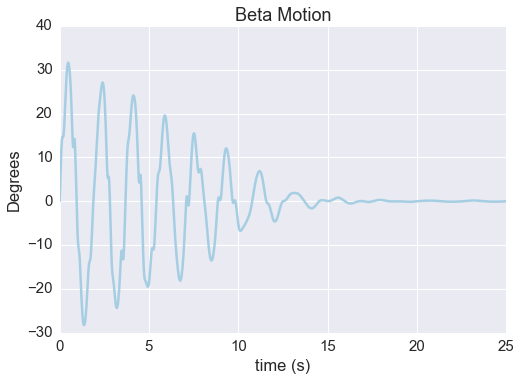

In [27]:
plt.figure(6)
# plt.subplot(211)
plt.plot(t, np.degrees(resp[:,2]))
# plt.plot(t,resp[:,0])
plt.title('Beta Motion')
plt.xlabel('time (s)')
plt.ylabel('Degrees')

In [ ]:
def CRAWLAB_fft(data,time,plotflag):
    ''' Function to get the FFT for a response
    #
    # Inputs:
    #   time = time array corresponding to the data
    #   data = the response data array (only pass a single dimension/state at at time)
    #   plotflag = will plot the FFT if nonzero
    #   
    # Output:
    #   fft_freq = an array of the freqs used in the FFT
    #   fft_mag = an array of the amplitude of the FFT at each freq in fft_freq
    #
    # Created: 03/28/14
    #   - Joshua Vaughan
    #   - joshua.vaughan@louisiana.edu
    #   - http://www.ucs.louisiana.edu/~jev9637
    ######################################################################################
    '''
    
    from scipy.fftpack import fft
    
    # correct for any DC offset
    offset = np.mean(data) 

    # Get the natural frequency
    sample_time = time[1] - time[0]
    n = len(data)

    fft_mag = fft((data - offset)*np.hanning(len(data)))
    fft_freq = np.linspace(0.0, 1.0/(2.0*sample_time), n/2)
    
    # Only return the "useful" part of the fft
    fft_mag = 2.0/n * np.abs(fft_mag[0:n/2])
    
    if plotflag:
        # Plot the relationshiop
        #   Many of these setting could also be made default by the .matplotlibrc file
        fig = plt.figure(figsize=(6,4))
        ax = plt.gca()
        plt.subplots_adjust(bottom=0.17,left=0.17,top=0.96,right=0.96)
        plt.setp(ax.get_ymajorticklabels(),fontsize=18)
        plt.setp(ax.get_xmajorticklabels(),fontsize=18)
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.grid(True,linestyle=':',color='0.75')
        ax.set_axisbelow(True)

        plt.xlabel('Frequency (Hz)',fontsize=22,labelpad=8)
        plt.ylabel('FFT magnitude',fontsize=22,labelpad=10)
    
        plt.plot(fft_freq, fft_mag, linewidth=2, linestyle='-')
        
        # Adjust the page layout filling the page using the new tight_layout command
        plt.tight_layout(pad=0.5)
        plt.show()
    
    return fft_freq, fft_mag

In [ ]:
freq, mag = CRAWLAB_fft(resp[:,2][800:], t[800:],False)

In [ ]:
plt.figure(7)
plt.plot(freq, mag)
plt.title('FFT')
plt.xlabel('frequency')
plt.ylabel('Magnitude')
plt.xlim(0, 5)
freq_index = np.argmax(mag)
print freq[freq_index]

In [ ]:
np.size(response[:,2][400:])
np.size(sim_time[400:])